In [122]:
!date

Tue Sep  6 11:39:12 EDT 2022


In [123]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [179]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *
import shutil
from scipy.stats import ttest_ind,ttest_1samp,ttest_rel

import umap

CPU times: user 16 µs, sys: 21 µs, total: 37 µs
Wall time: 42.2 µs


In [207]:
#analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
#analysis_name = 'CVAE_Aug23_new_16DIM_S1558'
#analysis_name = 'CVAE_test'
#analysis_name = 'CVAE_16n_repl'
analysis_name = 'Sep2-DIM_16_16-beta-1e-6-gamma-1-filt64-v5'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [208]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [209]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [210]:
# YEO ROI NAMES
rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']

In [211]:
#df = pd.read_csv('../Data/comb_df.csv')
df = pd.read_csv('../Data/df_comb_S1558.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
#df['site_id'] = dummy_ordinal(df['site'])

u_sites = np.unique(df['siteID'].values)
sites = df['siteID'].values.astype(float)
site_ratios = np.array([(df['diag'].values[df['siteID'].values==s]==1).mean() for s in u_sites])
bad_sites = u_sites[abs(site_ratios-.5)>.1]
sites[df['siteID'].isin(bad_sites).values] = np.nan
df['sites_bal'] = sites
print((~np.isnan(df['sites_bal'].values)).sum())


patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

1026
(699, 36)
(859, 36)


,Unnamed: 0,Unnamed: 0.1,subID,diag,DSMIV,age,gender,handedness_cat,handedness_score,fiq,...,sqc_total,aq_total,comorbidity,bmi,vineland_sum,dataset,siteID,sub,dataset_id,sites_bal
0,2,2,50004,1,1.0,19.09,1,R,NaN,113.0,...,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050004,1,26.0
1,8,8,50010,1,1.0,35.20,1,L,NaN,81.0,...,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050010,1,26.0
2,9,9,50011,1,1.0,16.93,1,L,NaN,111.0,...,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050011,1,26.0
3,10,10,50012,1,1.0,21.48,1,R,NaN,128.0,...,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050012,1,26.0
4,12,12,50014,1,1.0,14.20,1,R,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,ABIDE1,26,sub-0050014,1,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,2050,746,30163,2,NaN,8.00,2,1.0,81.25,136.0,...,1.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30163,2,NaN
1554,2051,747,30164,2,NaN,10.00,2,1.0,100.00,115.0,...,2.0,NaN,none,NaN,NaN,ABIDE2,23,sub-30164,2,NaN
1555,2052,748,30165,2,NaN,12.00,2,1.0,100.00,120.0,...,NaN,NaN,none,NaN,NaN,ABIDE2,23,sub-30165,2,NaN
1556,2053,749,30166,2,NaN,10.00,2,1.0,100.00,112.0,...,4.0,NaN,tourettes/tics,NaN,NaN,ABIDE2,23,sub-30166,2,NaN


In [212]:
## Load Data
#cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
cmats = np.load('../Data/cmats_S1558.npz')['cmats']
#cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

print(cmats.shape)
#print(cmats_rel.shape)
print(cmats_asd_flat.shape)

(1558, 51, 51)
(699, 1275)


In [213]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed

In [214]:
def plot_scatterbar(inData,lbls):
#inData = [v1,v2]
#lbls = ['LH','RH']
    n = len(inData)

    plt.bar(np.arange(n),[v.mean() for v in inData],alpha=.5)

    for i in range(n):
        ys = inData[i]
        xs = np.ones(ys.shape)*i
        xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
        plt.scatter(xs,ys);

    plt.xticks(np.arange(n),labels=lbls);

In [215]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

# data['recon_td_mu'] = depad(data['recon_td_mu'])
# data['recon_asd_mu'] = depad(data['recon_asd_mu'])
# data['recon_twin_mu'] = depad(data['recon_twin_mu'])
# data['recon_td_samples'] = depad(data['recon_td_samples'])
# data['recon_asd_samples'] = depad(data['recon_asd_samples'])
# data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['recon_td_mu'] = data['recon_td_mu']
data['recon_asd_mu'] = data['recon_asd_mu']
data['recon_twin_mu'] = data['recon_twin_mu']
data['recon_td_samples'] = data['recon_td_samples']
data['recon_asd_samples'] = data['recon_asd_samples']
data['recon_twin_samples'] = data['recon_twin_samples']

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

FileNotFoundError: [Errno 2] No such file or directory: '../Assets/tf_weights/Sep2-DIM_16_16-beta-1e-6-gamma-1-filt64-v5/results.npz'

In [216]:
v1 = ((cmats[patients,:,:]-data['recon_asd_mu'])**2).mean(axis=-1).mean(axis=-1)
v2 = ((cmats[~patients,:,:]-data['recon_td_mu'])**2).mean(axis=-1).mean(axis=-1)
v3 = ((cmats[patients,:,:]-data['recon_twin_mu'])**2).mean(axis=-1).mean(axis=-1)

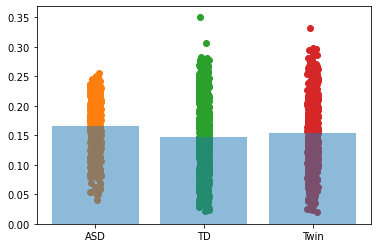

In [217]:
plot_scatterbar([v1,v2,v3],['ASD','TD','Twin'])

In [218]:
ttest_ind(v1,v2)

Ttest_indResult(statistic=7.525696331307493, pvalue=8.828764654904699e-14)

In [219]:
ttest_rel(v1,v3)

Ttest_relResult(statistic=15.742765486635642, pvalue=5.187779235938216e-48)

In [220]:
m1 = np.random.rand(100,100)
m2 = np.random.rand(100,100)
m3 = np.random.rand(100,100)

In [221]:
def fit_rsa(rdm_data,rdm_model,measure='pearson',cov=None):
    from scipy.stats import kendalltau
    from pingouin import partial_corr
    
    if measure=='pearson':
        r = np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    elif measure=='kendall':
        r = kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif measure=='partial_kendall':
        arr = pd.DataFrame(np.array([get_triu(rdm_data),get_triu(rdm_model),get_triu(cov)]).transpose(),columns=['x','y','cv1'])
        r = partial_corr(data=arr, x='x', y='y', covar='cv1')['r'].values[0]
            
    return r

In [195]:
def key_rsa_partial(inMat,key,model_scale,df,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    
    cov = make_RDM(df_asd['siteID'].values[~e],data_scale='ordinal', metric='euclidean')
    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='partial_kendall',cov=cov) for i in range(10)])
        

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [196]:
def key_rsa(inMat,key,model_scale,df,return_models=False):
    vec = df[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=model_scale, metric='euclidean')
    models = []
    model_fit = []

    # Make models
    for i in range(len(inMat)):
        mat = inMat[i]['data']
        metric = inMat[i]['metric']
        data_scale = inMat[i]['data_scale']

        if mat.ndim==3:
            model_data = np.array([make_RDM(mat[i,~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        elif mat.ndim==2:
            model_data = np.array([make_RDM(mat[~e,:],data_scale=data_scale, metric=metric) for i in range(10)])
        models.append(model_data)

    for m in range(len(models)):
        model_fit.append([fit_rsa(models[m][i,:,:],model_rdm,measure='kendall') for i in range(10)])

    res = np.array(model_fit).transpose()

    if return_models==True:
        return res,models
    else:
        return res

In [197]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True,lbls=['VAE','BG','SL']):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = lbls.copy()
    
    plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(len(xlbls))])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = lbls.copy()
        for i in range(1,c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(len(xlbls)),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = lbls.copy()

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [198]:
diffmat = (data['recon_asd_mu']-data['recon_twin_mu'])

In [199]:
v1 = {'label' : 'CMAT', 'data' : cmats_asd_flat, 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'DMAT', 'data' : flatten_cmat(diffmat), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'BG', 'data' : data['Z_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'SL', 'data' : data['S_asd_sample10'], 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [200]:
inMat = [v1,v2,v3,v4]

In [201]:
rsa_res = dict()
#keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
keys = ['dataset_id', 'sites_bal','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

100%|██████████| 10/10 [01:13<00:00,  7.38s/it]


In [202]:
rsa_res2 = dict()
#keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
keys = ['dataset_id', 'sites_bal','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res2.update({keys[i] : key_rsa_partial(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

100%|██████████| 10/10 [01:22<00:00,  8.29s/it]


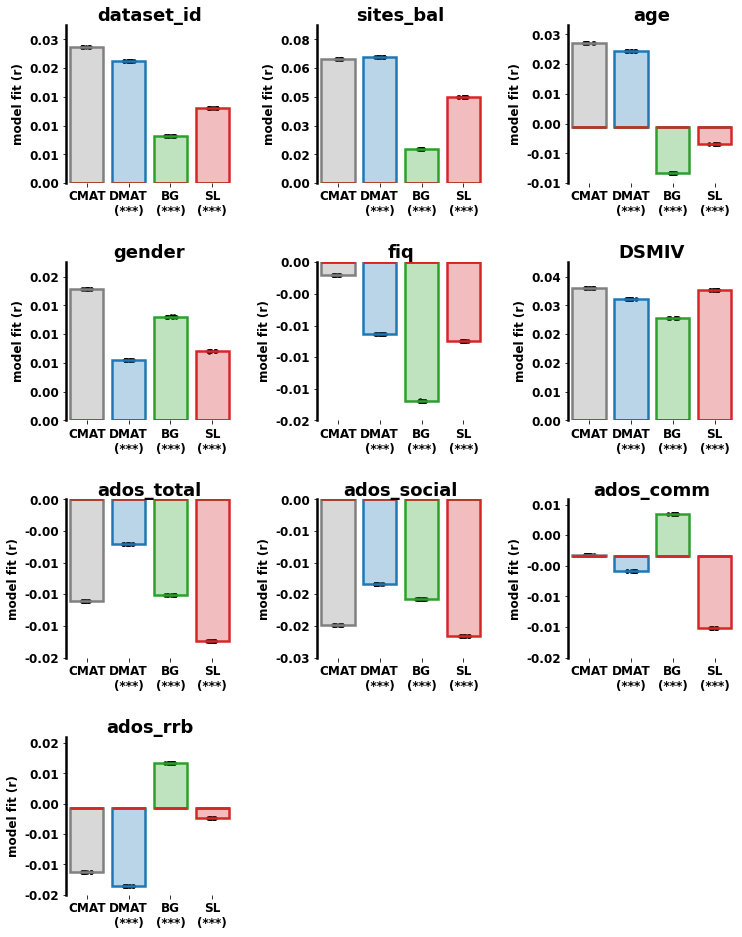

In [203]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [204]:
temp = [rsa_res[key][0,:] for key in rsa_res.keys()]
temp = np.array(temp)
rsa_df = pd.DataFrame(temp.transpose(),columns=['dataset_id', 'sites_bal','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb'])
rsa_df['feat'] = ['CMAT','DMAT','BG','SL']
rsa_df.to_csv(os.path.join(save_dir,'rsa_df.csv'))

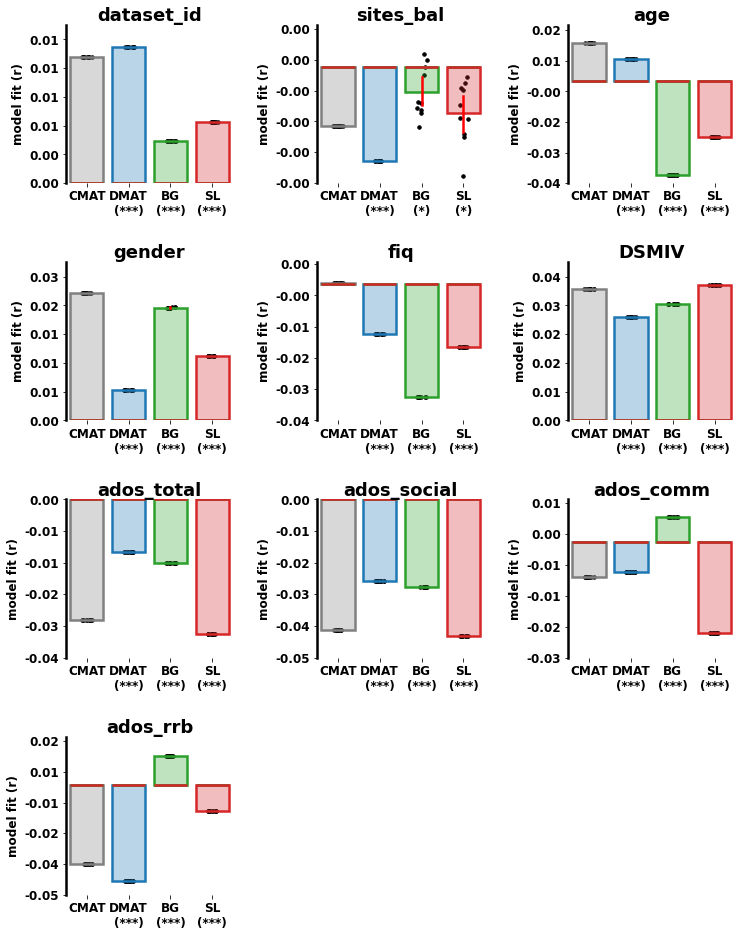

In [205]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res2,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [206]:
temp = [rsa_res2[key][0,:] for key in rsa_res.keys()]
temp = np.array(temp)
rsa_df = pd.DataFrame(temp.transpose(),columns=['dataset_id', 'sites_bal','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb'])
rsa_df['feat'] = ['CMAT','DMAT','BG','SL']
rsa_df.to_csv(os.path.join(save_dir,'rsa_df_partialled.csv'))

In [31]:
td1 = {'label' : 'CMAT', 'data' : flatten_cmat(cmats[~patients,:,:]), 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td2 = {'label' : 'BG', 'data' : data['Z_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
td3 = {'label' : 'SL', 'data' : data['S_mu'][~patients,:], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
tdMat = [td1,td2,td3]

rsa_res_td = dict()
#keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq']
keys = ['dataset_id', 'sites_bal','age', 'gender', 'fiq']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res_td.update({keys[i] : key_rsa(tdMat,keys[i],df=df.iloc[~patients],model_scale=data_scale[i])})

100%|██████████| 5/5 [00:41<00:00,  8.33s/it]


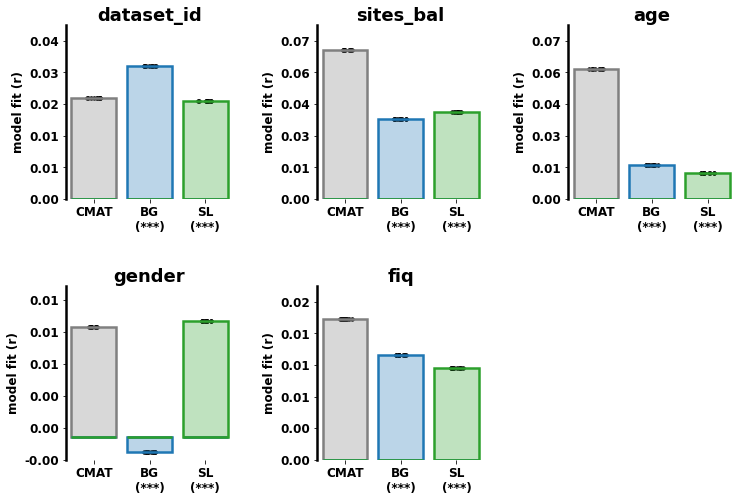

In [32]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res_td,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[tdMat[j]['label'] for j in range(len(tdMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [33]:
(df.iloc[patients]['gender'].values==1).mean()

0.882689556509299

In [34]:
(df.iloc[~patients]['gender'].values==1).mean()

0.7613504074505238

In [ ]:
def get_bic(inMat,k,covariance_type='full'):
    from sklearn.mixture import GaussianMixture as gmm
    
    model = gmm(n_components=k,covariance_type=covariance_type)
    model.fit(inMat)
    return model.bic(inMat)

def get_bic_range(inMat,ks,covariance_type='full'):
    return [get_bic(inMat,k=i,covariance_type=covariance_type) for i in ks]

def norm(vec):
    return (vec - vec.min()) / (vec.max()-vec.min())

In [ ]:
bic_z = np.array([get_bic_range(data['Z_mu'][patients,:],np.arange(2,11)) for i in tqdm(range(100))])
bic_s = np.array([get_bic_range(data['S_mu'][patients,:],np.arange(2,11)) for i in tqdm(range(100))])

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);
plt.plot(bic_z.mean(axis=0))
plt.fill_between(np.arange(9),y1=bic_z.min(axis=0),y2=bic_z.max(axis=0),alpha=.5)
plt.title('Z BIC');
plt.xticks(np.arange(9),labels=np.arange(2,11));


plt.subplot(1,3,2);
plt.plot(bic_s.mean(axis=0))
plt.fill_between(np.arange(9),y1=bic_s.min(axis=0),y2=bic_s.max(axis=0),alpha=.5)
plt.title('S BIC');
plt.xticks(np.arange(9),labels=np.arange(2,11));

plt.subplot(1,3,3)
plt.plot(norm(bic_z.mean(axis=0)))
plt.plot(norm(bic_s.mean(axis=0)))
plt.xticks(np.arange(9),labels=np.arange(2,11));

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# c_idx_s = KMeans(n_clusters=3).fit_predict(data['S_mu'][patients,:])
# c_idx_z = KMeans(n_clusters=3).fit_predict(data['Z_mu'][patients,:])
# adjusted_rand_score(c_idx_s,c_idx_z)

In [ ]:
data.keys()

In [ ]:
diff_sim = np.corrcoef(flatten_cmat(diffmat))
diff_sim[np.isnan(diff_sim)]=0

In [ ]:
plt.imshow(diff_sim)

In [ ]:
bic_d = np.array([get_bic_range(diff_sim,np.arange(2,101),covariance_type='spherical') for i in tqdm(range(10))])

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(bic_d.mean(axis=0))
plt.fill_between(np.arange(bic_d.shape[1]),y1=bic_d.min(axis=0),y2=bic_d.max(axis=0),alpha=.5)
plt.title('D BIC');
plt.xticks(np.arange(bic_d.shape[1]),labels=np.arange(2,2+bic_d.shape[1]));

In [ ]:
f'Clusters in diffsim = {np.argmin(bic_d.mean(axis=0))+2}'

In [ ]:
#c_idx_s = KMeans(n_clusters=3).fit_predict(PCA(n_components=5).fit_transform(flatten_cmat(diffmat)))
c_idx_s = KMeans(n_clusters=12).fit_predict(diff_sim)
uc = np.unique(c_idx_s)

plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(diffmat[c_idx_s==uc[i],:,:].mean(axis=0))
    plt.xticks([]);plt.yticks([]);
    plt.clim(-.1,.1)
    plt.title(i)

plt.subplots_adjust(
    left=0,
    bottom=0,
    right=0.5,
    top=0.5,
    wspace=0.1,
    hspace=0.1)

In [ ]:
plt.figure(figsize=np.array((25,20))*.5)
sns.heatmap(diffmat.mean(axis=0),xticklabels=rnames,yticklabels=rnames)

In [ ]:
#ys = abs(diffmat).sum(axis=1).mean(axis=0)
ys = diffmat.sum(axis=1).mean(axis=0)
xs = np.arange(len(ys))

plt.figure(figsize=(5,20))
plt.barh(xs,ys)
plt.yticks(xs,labels=rnames,rotation=0);

In [ ]:
from scipy.stats import ttest_1samp

In [ ]:
tmat = np.zeros((51,51))
pmat = np.zeros((51,51))
for i in range(51):
    for j in range(51):
        t_res = ttest_1samp(diffmat[:,i,j],0)
        tmat[i,j] = t_res[0]
        pmat[i,j] = t_res[1]

In [ ]:
plt.subplot(1,2,1)
plt.imshow(abs(tmat))
plt.subplot(1,2,2)
plt.imshow(pmat < .05/len(get_triu(pmat)))

In [ ]:
idx_lh = np.array([rname.startswith('LH') for rname in rnames])
idx_rh = np.array([rname.startswith('RH') for rname in rnames])

In [ ]:
v1 = abs(flatten_cmat(diffmat[:,idx_lh,:][:,:,idx_lh])).mean(axis=0)
v2 = abs(flatten_cmat(diffmat[:,idx_rh,:][:,:,idx_rh])).mean(axis=0)
plt.bar([0,1],[v1.mean(),v2.mean()],alpha=.5)

ys = v1
xs = np.ones(ys.shape)*0
xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
plt.scatter(xs,ys)

ys = v2
xs = np.ones(ys.shape)*1
xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
plt.scatter(xs,ys)

plt.xticks([0,1],labels=['LH','RH'])

In [ ]:
nets = np.array([rname.split('-')[1] for rname in rnames])
unets = np.unique(nets)

In [ ]:
#netMat = np.zeros((7,7))
n = diffmat.shape[0]
netMat = np.zeros((n,7,7))
tmat = np.zeros((7,7))
pmat = np.zeros((7,7))

for i in range(7):
    for j in range(7):
        if i==j:
            netMat[:,i,j] = flatten_cmat(diffmat[:,nets==unets[i],:][:,:,nets==unets[j]]).mean(axis=-1).mean(axis=-1)
        else:
             netMat[:,i,j] = diffmat[:,nets==unets[i],:][:,:,nets==unets[j]].mean(axis=-1).mean(axis=-1)
        t = ttest_1samp(netMat[:,i,j],0)
        tmat[i,j] = t[0]
        pmat[i,j] = t[1]

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(netMat.mean(axis=0),annot=True,xticklabels=unets,yticklabels=unets)

In [ ]:
plt.hist(netMat.flatten())

In [ ]:
cmats_asd_flat.shape

In [ ]:
flatten_cmat(diffmat).shape

In [ ]:
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet,Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

In [ ]:
vec = df_asd[key].values
e = np.isnan(vec)

In [ ]:
#X = cmats_asd_flat[~e,:]
#X = PCA(n_components=15).fit_transform(X)

In [ ]:
from sklearn.linear_model import LogisticRegression,LinearRegression,ElasticNet,Ridge,BayesianRidge
model = BayesianRidge()

In [ ]:
def loso_crossval(X,Y,model):
    n = X.shape[0]
    Y_hat = []
    for i in tqdm(range(n)):
        svec = np.arange(n)

        train_idx = svec!=i
        test_idx = i

        X_train = X[train_idx,:]
        Y_train = Y[train_idx]

        X_test = X[test_idx,:][np.newaxis,:]
        Y_test = Y[test_idx]

        Y_hat.append(model.fit(X_train, Y_train).predict(X_test))
    Y_hat = np.array(Y_hat)[:,0]
    return Y_hat

In [ ]:
### PCA

In [ ]:
diffmat_asd_flat = flatten_cmat(diffmat)
diffmat_asd_flat.shape

In [ ]:
reducer = PCA()
comps = reducer.fit_transform(diffmat_asd_flat)
#comps = UMAP(n_components=10).fit_transform(diffmat_asd_flat)
#comps = reducer.fit_transform(cmats_asd_flat)
comps.shape

In [ ]:
# play = PCA(n_components=3)
# play.fit(diffmat_asd_flat)

In [ ]:
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr

In [ ]:
#comps[:,0]

In [ ]:
v1 = {'label' : 'PC1', 'data' : comps[:,0][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v2 = {'label' : 'PC2', 'data' : comps[:,1][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v3 = {'label' : 'PC3', 'data' : comps[:,2][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v4 = {'label' : 'PC4', 'data' : comps[:,3][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v5 = {'label' : 'PC5', 'data' : comps[:,4][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v6 = {'label' : 'PC6', 'data' : comps[:,5][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v7 = {'label' : 'PC7', 'data' : comps[:,6][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v8 = {'label' : 'PC8', 'data' : comps[:,7][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v9 = {'label' : 'PC9', 'data' : comps[:,8][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}
v10 = {'label' : 'PC10', 'data' : comps[:,9][:,np.newaxis], 'data_scale' : 'ratio', 'metric' : 'euclidean'}

In [ ]:
inMat = [v1,v2,v3,v4,v5,v6,v7,v8,v9,v10]

In [ ]:
rsa_res = dict()
#keys = ['dataset_id', 'sites_bal','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
keys = ['dataset_id', 'sites_bal','age', 'gender', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(inMat,keys[i],df=df_asd,model_scale=data_scale[i])})

In [ ]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i],lbls=[inMat[j]['label'] for j in range(len(inMat))])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [ ]:
r01 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,0]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r02 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,1]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r03 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,2]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r04 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,3]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r05 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,4]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r06 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,5]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r07 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,6]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r08 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,7]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r09 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,8]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])
r10 = np.array([pearsonr(diffmat_asd_flat[:,i],comps[:,9]) for i in tqdm(range(diffmat_asd_flat.shape[1]))])

In [ ]:
vec = r02
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/1275/10] = np.nan
sns.heatmap(mat1)

In [ ]:
# ys = np.nansum((mat1)>0,axis=0)
# xs = np.arange(len(ys))
# lbls = np.array(rnames)

# ys = ys[I]
# lbls = lbls[I]

# plt.figure(figsize=(25,5))
# plt.bar(xs,ys,alpha=.5)
# plt.xticks(xs,labels=lbls,rotation=90);

# ys = np.nansum((mat1)<0,axis=0)
# xs = np.arange(len(ys))
# plt.bar(xs,ys,alpha=.5)
# plt.xticks(xs,labels=lbls,rotation=90);

# plt.legend(['over-connected','under-connected'])

In [ ]:
rlbls = pd.DataFrame()
rlbls['rname'] = rnames
rlbls['hem'] = [val.split('-')[0] for val in rnames]
rlbls['net'] = [val.split('-')[1] for val in rnames]
rlbls['roi'] = [val.split('-')[2] for val in rnames]
rlbls['idx'] = np.arange(51)
rlbls.head()

In [ ]:
I = rlbls.sort_values(by=['roi','net','hem'])['idx'].values

In [ ]:
rlbls.iloc[I]

In [ ]:
def plot_connGraph(con,node_names):
    #N = 20  # Number of nodes
    #node_names = [f"N{i}" for i in range(N)]  # List of labels [N]

    # Random connectivity
    #ran = np.random.rand(N,N)-.5
    #ran[abs(ran)<.4]=np.nan
    #con = ran
    from mne.viz.circle import _plot_connectivity_circle
    _plot_connectivity_circle(con=con,
        node_names=node_names,
        indices=None,
        n_lines=None,
        node_angles=None,
        node_width=None,
        node_height=None,
        node_colors=None,
        facecolor='black',
        textcolor='white',
        node_edgecolor='black',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=8,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

In [ ]:
from mne.viz import circular_layout
from mne.viz.circle import _plot_connectivity_circle

In [ ]:
node_order = rnames
label_names = rnames

In [ ]:
plot_mat = mat1
plot_lbls = rnames

I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))

plot_mat = plot_mat[I,:][:,I]
plot_lbls = np.array(plot_lbls)[I]

net_colors = dict()
net_colors['Vis'] = np.array((147,74,146))/ 255
net_colors['SomMot'] = np.array((103,144,180))/ 255
net_colors['DorsAttn'] = np.array((50,142,60))/ 255
net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
net_colors['Limbic'] = np.array((247,250,201))/ 255
net_colors['Cont'] = np.array((243,177,82))/ 255
net_colors['Default'] = np.array((225,99,114)) / 255

nets = np.array([val.split('-')[1] for val in plot_lbls])
rois = np.array([val.split('-')[2] for val in plot_lbls])

node_colors = np.array([net_colors[net] for net in nets ])

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, 26])


#fig,ax = plt.subplots(1,1,figsize=(10,10))
_plot_connectivity_circle(con=plot_mat,
        node_names=rois,
        indices=None,
        n_lines=None,
        node_angles=node_angles,
        node_width=None,
        node_height=None,
        node_colors=node_colors,
        facecolor='black',
        textcolor='white',
        node_edgecolor='black',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=12,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

In [ ]:
from scipy.cluster.hierarchy import optimal_leaf_ordering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage

In [ ]:
temp = squareform(vec[:,0])

In [ ]:
vec = r03
mat1 = squareform(vec[:,0])
mat1[squareform(vec[:,1])>.05/(1275*10)] = np.nan

plot_mat = mat1
plot_lbls = rnames

I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))
#I = hierarchy.leaves_list(optimal_leaf_ordering(linkage(squareform(vec[:,0])),get_triu(squareform(vec[:,0]))))

plot_mat = plot_mat[I,:][:,I]
plot_lbls = np.array(plot_lbls)[I]

net_colors = dict()
net_colors['Vis'] = np.array((147,74,146))/ 255
net_colors['SomMot'] = np.array((103,144,180))/ 255
net_colors['DorsAttn'] = np.array((50,142,60))/ 255
net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
net_colors['Limbic'] = np.array((247,250,201))/ 255
net_colors['Cont'] = np.array((243,177,82))/ 255
net_colors['Default'] = np.array((225,99,114)) / 255

nets = np.array([val.split('-')[1] for val in plot_lbls])
rois = np.array([val.split('-')[2] for val in plot_lbls])

node_colors = np.array([net_colors[net] for net in nets ])

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, 26])


#fig,ax = plt.subplots(1,1,figsize=(10,10))
_plot_connectivity_circle(con=plot_mat,
        node_names=rois,
        indices=None,
        n_lines=None,
        node_angles=node_angles,
        node_width=None,
        node_height=None,
        node_colors=node_colors,
        facecolor='white',
        textcolor='black',
        node_edgecolor='white',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=12,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

In [ ]:
plt.hist(get_triu(mat1))

In [ ]:
plt.imshow(mat1[I,:][:,I])

In [ ]:
vec = reducer.components_[0,:]
mat1 = squareform(vec)
#mat1[squareform(vec[:,1])>.05/(1275*10)] = np.nan

plot_mat = mat1
plot_lbls = rnames

I = np.hstack((np.arange(25,-1,-1),np.arange(26,51,1)))
#I = hierarchy.leaves_list(optimal_leaf_ordering(linkage(squareform(vec[:,0])),get_triu(squareform(vec[:,0]))))

plot_mat = plot_mat[I,:][:,I]
plot_lbls = np.array(plot_lbls)[I]

net_colors = dict()
net_colors['Vis'] = np.array((147,74,146))/ 255
net_colors['SomMot'] = np.array((103,144,180))/ 255
net_colors['DorsAttn'] = np.array((50,142,60))/ 255
net_colors['SalVentAttn'] = np.array((184,102,169))/ 255
net_colors['Limbic'] = np.array((247,250,201))/ 255
net_colors['Cont'] = np.array((243,177,82))/ 255
net_colors['Default'] = np.array((225,99,114)) / 255

nets = np.array([val.split('-')[1] for val in plot_lbls])
rois = np.array([val.split('-')[2] for val in plot_lbls])

node_colors = np.array([net_colors[net] for net in nets ])

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, 26])


#fig,ax = plt.subplots(1,1,figsize=(10,10))
_plot_connectivity_circle(con=plot_mat,
        node_names=rois,
        indices=None,
        n_lines=5,
        node_angles=node_angles,
        node_width=None,
        node_height=None,
        node_colors=node_colors,
        facecolor='black',
        textcolor='white',
        node_edgecolor='black',
        linewidth=1.5,
        colormap='bwr',
        vmin=None,
        vmax=None,
        colorbar=True,
        title=None,
        colorbar_size=.5,
        colorbar_pos=None,
        fontsize_title=12,
        fontsize_names=12,
        fontsize_colorbar=8,
        padding=2.0,
        ax=None,
        interactive=True,
        node_linewidth=4.0,
        show=True)

In [ ]:
data.keys()

In [ ]:
df.columns

In [ ]:
!date